# Introduction to $k$-Nearest Neighbors and Clustering

## Prerequisites

* Preliminaries:
    * Classification
    * Classification Metrics


* For Better Clustering:
    * Manifold Learning
    * ANOVA - Analysis of Variance

## Learning Goals

By the end of this lecture a student should be able to:

* Explain the differences between Classification and Clustering.
* Explain how $k$-NN Classification and $k$-Means Clustering are similar.
* Explain how $k$-Means Clustering differs from Hierarchical Clustering.
* Explain how to choose the number of clusters.

Above and Beyond:

* Explain the difficulties in choosing a suitable algorithm / notion of distance.
* Explain how unsupervised methods such as clustering and segmentation are useful for data exploration, feature engineering, and modeling.

## Imports

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.datasets import make_classification

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score, mutual_info_score, calinski_harabasz_score, balanced_accuracy_score
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score
from sklearn.metrics.cluster import contingency_matrix

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, silhouette_score

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from collections import Counter
from umap import UMAP

from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import feature_importance_permutation

import gc; gc.enable()

import warnings
warnings.filterwarnings("ignore")

C:\Users\purem\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Helper Functions

In [2]:
def ANOVA(data, cluster_col, excluded_cols=[], sort_by='mean', ascending=True):
    used_cols = [c for c in data.columns.tolist() if c not in excluded_cols]
    X = data[used_cols]
    X = data/(data.max()-data.min())
    return X.groupby(cluster_col).var().agg(['mean', 'min', 'max']).T.sort_values(by=sort_by, ascending=ascending)


def elbow_plot(model, data, stop=8):
    # distortion plot
    visualizer = KElbowVisualizer(model, k=(2,stop+1),  
                              timings=False)

    visualizer.fit(data)        
    visualizer.show()        
    plt.show()

    # silhouette plot
    visualizer = KElbowVisualizer(model, k=(2, stop+1), 
                                  metric='silhouette', 
                                  timings=False)

    visualizer.fit(data)        
    visualizer.show()        
    plt.show()

    # c-h index plot
    visualizer = KElbowVisualizer(model, k=(2, stop+1), 
                                  metric='calinski_harabasz', 
                                  timings=False)

    visualizer.fit(data)        
    visualizer.show()        
    plt.show()

    
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# Example

In [3]:
X, y = make_classification(random_state=42)
used_cols = ["feat_"+str(i) for i in range(20)]
df = pd.DataFrame(X, columns=used_cols)
target = 'target'
df[target]= y
del X; del y; gc.collect()

df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,target
0,-2.025143,0.029102,-0.474945,-0.114736,0.504987,0.088962,0.404982,-0.653329,0.186454,-0.661786,...,2.143944,1.765454,0.852433,0.633919,0.087142,-0.792521,-0.334501,0.865755,-1.200296,0
1,1.613711,0.659924,-0.150056,-1.227608,0.597400,0.865620,0.015579,0.125576,0.453534,-0.244157,...,0.321357,-0.173072,0.964087,0.421921,0.963360,1.189470,1.375707,0.701173,-0.297564,0
2,0.166452,0.950573,1.420504,-0.530997,-0.623141,-2.255540,0.471416,-0.570746,0.492451,0.289169,...,-1.122722,-0.832356,2.455300,0.382410,-1.692005,-0.637740,1.189017,-0.555477,-0.637387,1
3,0.698223,-0.320670,1.735964,-0.535235,1.317394,-1.146581,-0.483886,0.197911,0.393485,0.895193,...,0.059630,-0.651418,0.635172,-0.646937,-1.106450,1.049553,-0.689188,0.197600,2.075261,1
4,0.179894,-0.222100,0.105376,0.940771,-0.982487,1.560103,0.319782,-1.334025,1.392002,0.918317,...,-0.988591,-0.601368,-1.570501,-1.103589,1.303736,-0.989628,-0.968344,-0.224633,0.550052,0


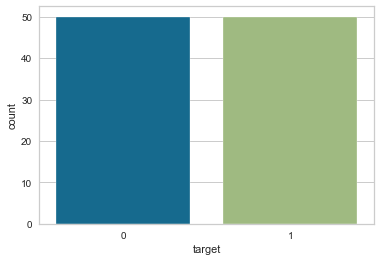

In [4]:
X, y = df[used_cols], df[target]

plt.figure()
sns.countplot(x=target, data=df)
plt.show()

# $k$-Nearest Neighbors

See: https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

In [5]:
X, y = df[used_cols], df[target]

knn = KNeighborsClassifier(n_jobs=-1)

scores = cross_val_score(knn, X, y, cv=5, scoring='balanced_accuracy')
print(scores.mean(), "+/-", scores.std())

0.95 +/- 0.031622776601683784


Let's see which features are the most valuable to our model.

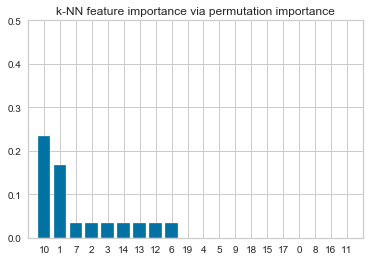

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, stratify=y.values, random_state=42)
knn.fit(X_train, y_train)


imp_vals, _ = feature_importance_permutation(
    predict_method=knn.predict, 
    X=X_test,
    y=y_test,
    metric='accuracy',
    num_rounds=1,
    seed=1)

indices = np.argsort(imp_vals)[::-1]
plt.figure()
plt.title("k-NN feature importance via permutation importance")
plt.bar(range(X.shape[1]), imp_vals[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.5])
plt.show()

In [7]:
X = df[['feat_1', 'feat_10']]

knn = KNeighborsClassifier(n_jobs=-1)

scores = cross_val_score(knn, X, y, cv=5, scoring='balanced_accuracy')
print(scores.mean(), "+/-", scores.std())

0.95 +/- 0.05477225575051658


**Note**: It appears all of the useful information is containted in *feat_1* and *feat_10*.

But finding the structure / information in your data is always easier when you know what you are looking for. That is, in a supervised task, such as classification, the problem of determining where the relevant information lives is the same as finding the discriminative power which you can do since you know the class labels.

**Question**: Could we do just as well if we took away the labels?

**Answer**: Typically, no. But we can do pretty well via clustering intelligently.

# $k$-Means

See: 

* https://scikit-learn.org/stable/modules/clustering.html
* https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py
* https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html#sphx-glr-auto-examples-cluster-plot-cluster-iris-py

In [8]:
X = df[used_cols]

clust = KMeans(n_clusters=2, n_jobs=-1, random_state=42)

labels = clust.fit_predict(X)
labels[:5]

array([1, 0, 0, 1, 1])

In [9]:
contingency_matrix(y, labels)

array([[38, 12],
       [ 4, 46]])

In [10]:
balanced_accuracy_score(y, labels)

0.8400000000000001

We recovered a lot of the information without the class labels via clustering. Can we do better?

First, we need to get the lay of the land...

## Clustering Metrics

In [11]:
print(silhouette_score(X, y))
print(silhouette_score(X, labels))

0.09896524168339686
0.12267997428755191


In [12]:
print(mutual_info_score(y, y))
print(mutual_info_score(y, labels))

0.6931471805599458
0.26536735026437386


In [13]:
print(calinski_harabasz_score(X, y))
print(calinski_harabasz_score(X, labels))

12.672567522276745
15.792404356023042


In [14]:
print(completeness_score(y, y))
print(completeness_score(y, labels))

1.0
0.39007859888021423


In [15]:
print(homogeneity_score(y, y))
print(homogeneity_score(y, labels))

1.0
0.3828441602402564


In [16]:
print(v_measure_score(y, y))
print(v_measure_score(y, labels))

1.0
0.386427522941435


## How do we choose $k$?

### Elbow Plots: Distortion, Silhouette, and Calinski-Harabasz

See: https://en.wikipedia.org/wiki/Elbow_method_(clustering)

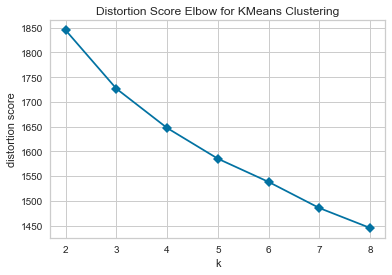

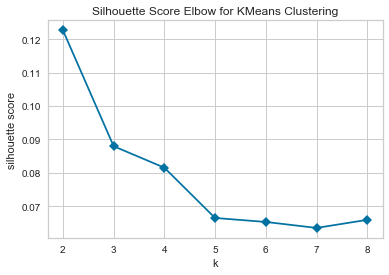

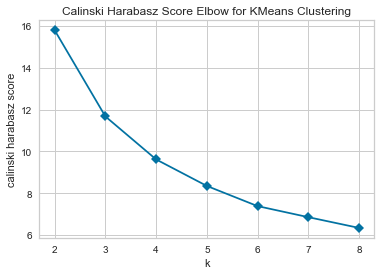

In [17]:
model = KMeans(n_jobs=-1, random_state=42)

elbow_plot(model, X)

### Silhouette Plots

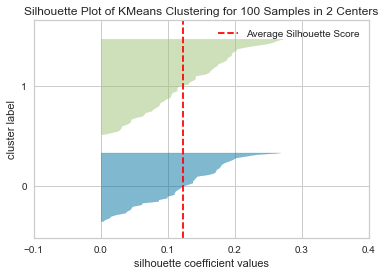

In [18]:
from yellowbrick.cluster import SilhouetteVisualizer


clust = KMeans(n_clusters=2, n_jobs=-1, random_state=42)
visualizer = SilhouetteVisualizer(clust, colors='yellowbrick')

visualizer.fit(X)      
visualizer.show()       
plt.show()

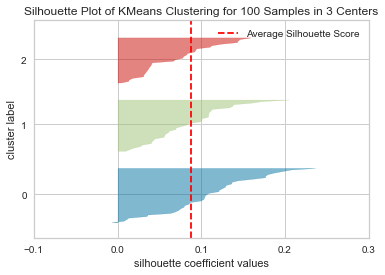

In [19]:
clust = KMeans(n_clusters=3, n_jobs=-1, random_state=42)
visualizer = SilhouetteVisualizer(clust, colors='yellowbrick')

visualizer.fit(X)       
visualizer.show()        
plt.show()

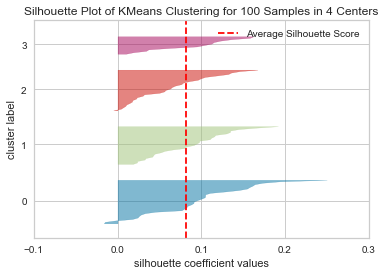

In [20]:
clust = KMeans(n_clusters=4, n_jobs=-1, random_state=42)
visualizer = SilhouetteVisualizer(clust, colors='yellowbrick')

visualizer.fit(X)       
visualizer.show()        
plt.show()

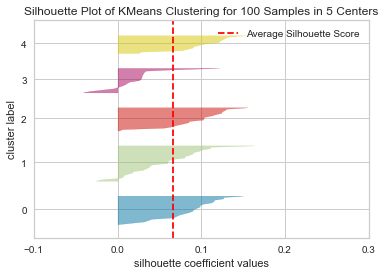

In [21]:
clust = KMeans(n_clusters=5, n_jobs=-1, random_state=42)
visualizer = SilhouetteVisualizer(clust, colors='yellowbrick')

visualizer.fit(X)       
visualizer.show()        
plt.show()

### Inter-Cluster Distance Plots

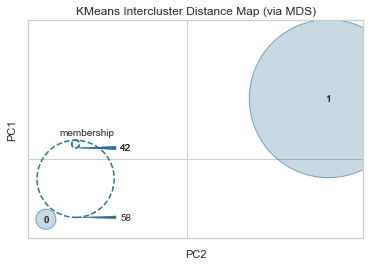

In [22]:
clust = KMeans(n_clusters=2, n_jobs=-1, random_state=42)
visualizer = InterclusterDistance(clust)

visualizer.fit(X)       
visualizer.show()        
plt.show()

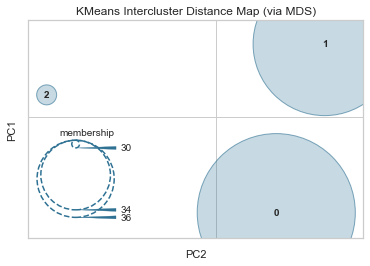

In [23]:
clust = KMeans(n_clusters=3, n_jobs=-1, random_state=42)
visualizer = InterclusterDistance(clust)

visualizer.fit(X)       
visualizer.show()        
plt.show()

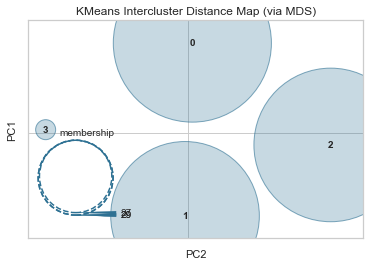

In [24]:
clust = KMeans(n_clusters=4, n_jobs=-1, random_state=42)
visualizer = InterclusterDistance(clust)

visualizer.fit(X)       
visualizer.show()        
plt.show()

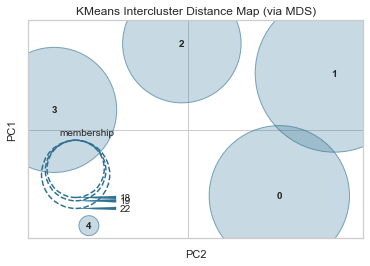

In [25]:
clust = KMeans(n_clusters=5, n_jobs=-1, random_state=42)
visualizer = InterclusterDistance(clust)

visualizer.fit(X)       
visualizer.show()        
plt.show()

### Choose: $k$=4. How does this perform?

In [26]:
clust = KMeans(n_clusters=4, n_jobs=-1, random_state=42)

labels = clust.fit_predict(X)
labels[:5]

array([3, 3, 0, 2, 1])

In [27]:
Counter(labels)

Counter({3: 13, 0: 31, 2: 29, 1: 27})

In [28]:
contingency_matrix(y, labels)

array([[29,  6,  2, 13],
       [ 2, 21, 27,  0]])

In [29]:
labels = pd.Series(labels).map({0:0, 1:1, 2:1, 3:0})

In [30]:
balanced_accuracy_score(y, labels)

0.8999999999999999

We improved our score from a 84% to roughly 90% by choosing what we suspect to be a better choice of $k$.

## What is a suitable notion of distance?

### Manifold Learning - Make Everything Euclidean

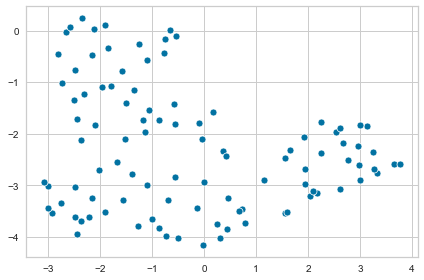

In [31]:
embed = UMAP(n_components=2, n_neighbors=5, learning_rate=0.2, random_state=42)

X_latent = embed.fit_transform(X)

plt.figure()
sns.scatterplot(x=X_latent[:,0], y=X_latent[:,1])
plt.tight_layout()
plt.show()

### Support Vector Machine - Sanity Check

Let's make sure a classifier can still perfom well in the latent space.

In [32]:
svm = SVC()

scores = cross_val_score(svm, X_latent, y, cv=5, scoring='balanced_accuracy')
print(scores.mean(), "+/-", scores.std())

0.93 +/- 0.03999999999999999


### Does the optimal $k$ become more apparent?

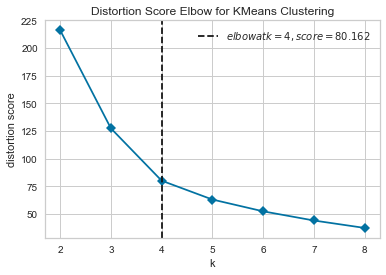

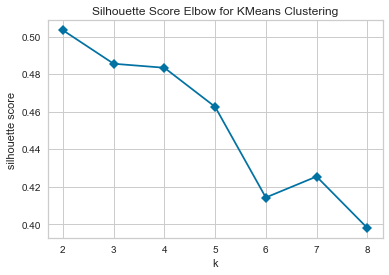

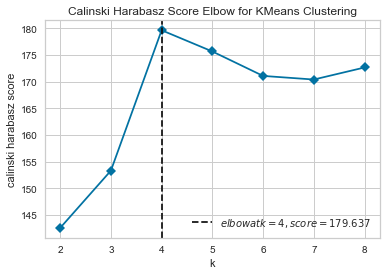

In [33]:
model = KMeans(n_jobs=-1, random_state=42)

elbow_plot(model, X_latent)

### How does $k=4$ perform in the latent space?

In [34]:
clust = KMeans(n_clusters=4, n_jobs=-1, random_state=42)

labels = clust.fit_predict(X_latent)
labels[:5]

array([1, 3, 1, 2, 3])

In [35]:
Counter(labels)

Counter({1: 27, 3: 24, 2: 31, 0: 18})

In [36]:
contingency_matrix(y, labels)

array([[ 3, 26,  2, 19],
       [15,  1, 29,  5]])

In [37]:
clusters = labels
labels = pd.Series(clusters).map({0:1, 1:0, 2:1, 3:0})

In [38]:
balanced_accuracy_score(y, labels)

0.89

# On which features should we cluster?

What are clustering on? Does it make sense? Unsupervised methods have a hard time coping with a low signal-to-noise ratio.

In the real world, you tend to know a priori what you would like to segment on, e.g.:
* latitudes and longitudes,
* credit card payment histories, age, gender, and education,
* recency, frequency, and monetary value of past purchases,
* time spent on a site, mouse-movements, and numbers of ads clicked,
* etc.

But sometimes it is not as apparent where the important information lives. One way to approach the problem in these situations is via Analysis of Variance.

## ANOVA

See: https://en.wikipedia.org/wiki/Analysis_of_variance

* Let's assume there are only $k=2$ important clusters. 
* Find them via $k$-Means. 
* Conduct an Analysis of Variance.
* Select the most informative features.
* Re-test our assumptions about $k$ and refine our hypothesis if need be.

In [39]:
clust = KMeans(n_clusters=2, n_jobs=-1, random_state=42)

labels = clust.fit_predict(X_latent)
df['clusters'] = labels

anova = ANOVA(df, 'clusters')
anova.head(8)

,mean,min,max
feat_1,0.017544,0.013439,0.021649
feat_10,0.019514,0.012293,0.026736
feat_18,0.031238,0.026514,0.035961
feat_7,0.032059,0.031907,0.032211
feat_4,0.032836,0.026624,0.039047
feat_9,0.034596,0.031388,0.037804
feat_3,0.037540,0.036200,0.038880
feat_16,0.038401,0.037011,0.039790


### Is the optimal $k$ apparent now?

Let's take the top three features from the Analysis of Variance and re-evaluate $k$.

In [40]:
used_cols = anova.head(3).index.tolist()
X = df[used_cols]

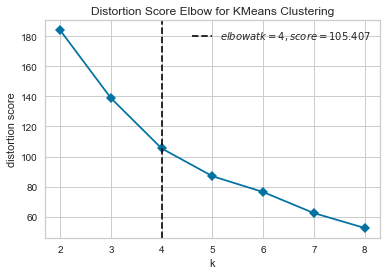

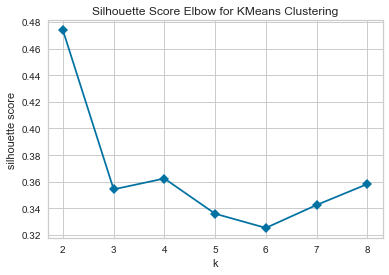

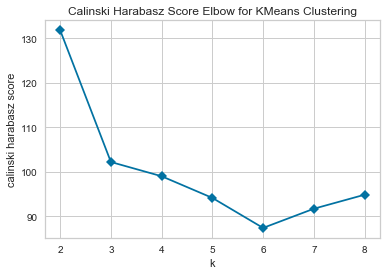

In [41]:
model = KMeans(n_jobs=-1, random_state=42)

elbow_plot(model, X)

### Does a manifold embedding help?

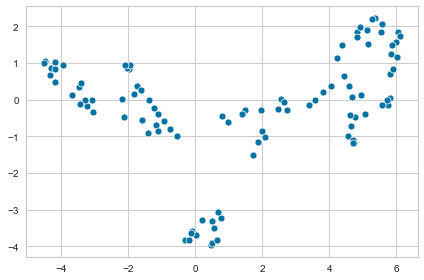

In [42]:
embed = UMAP(n_components=2, n_neighbors=8, learning_rate=0.2, random_state=42)

X_latent = embed.fit_transform(X)

plt.figure()
sns.scatterplot(x=X_latent[:,0], y=X_latent[:,1])
plt.tight_layout()
plt.show()

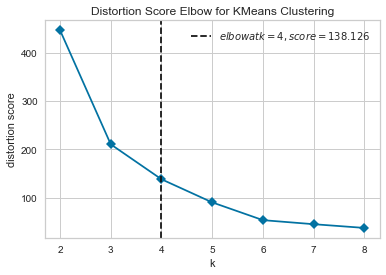

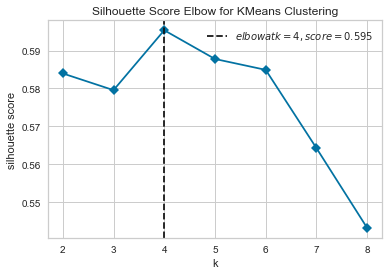

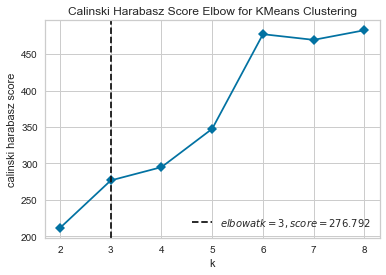

In [43]:
model = KMeans(n_jobs=-1, random_state=42)

elbow_plot(model, X_latent)

### Clustering Done Right...

Now that we know:
* a "good" choice for $k$,
* a "good" set of features to cluster on,
* the "right" notion of distance (a "decent" embedding)

... let's see how well clustering compares to our $k$-NN classifier.

In [44]:
clust = KMeans(n_clusters=4, n_jobs=-1, random_state=42)

labels = clust.fit_predict(X_latent)
labels[:5]

array([3, 3, 1, 0, 0])

In [45]:
Counter(labels)

Counter({3: 13, 1: 35, 0: 15, 2: 37})

In [46]:
contingency_matrix(y, labels)

array([[ 4, 34,  1, 11],
       [11,  1, 36,  2]])

In [47]:
clusters = labels
labels = pd.Series(clusters).map({0:1, 1:0, 2:1, 3:0})

In [48]:
balanced_accuracy_score(y, labels)

0.9199999999999999

# Yay!!

We did it! We were able to recover almost all of the "information" in the unlabelled data via clustering as we captured via classifing.

# Hierarchical Clustering

## Agglomerative Clustering

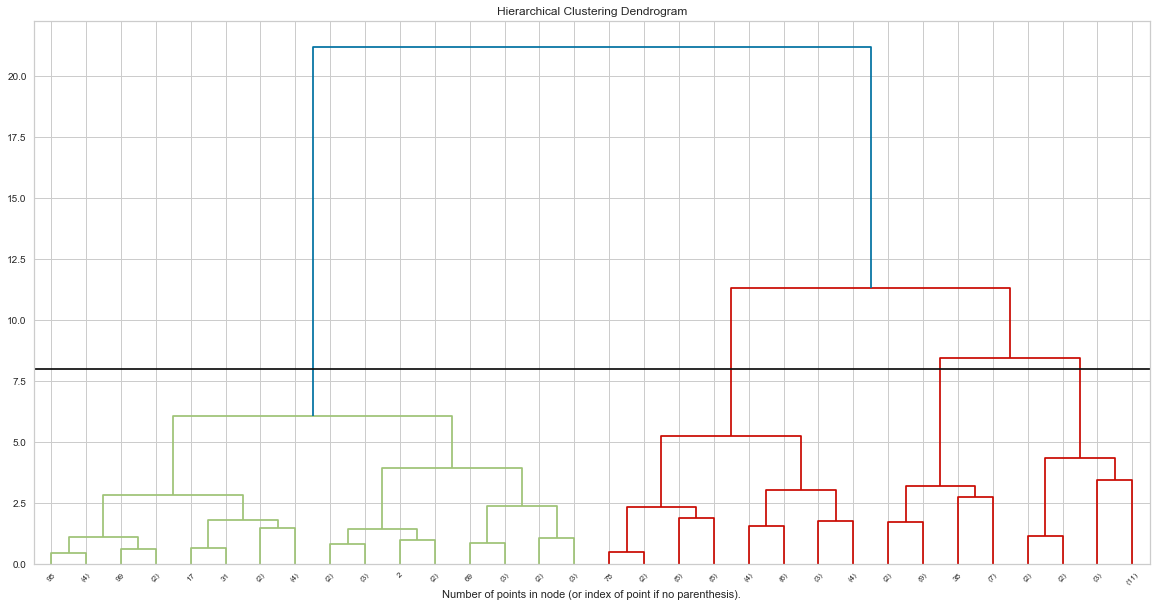

In [49]:
X, y = df[used_cols], df[target]
    
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)

plt.figure(figsize=(20,10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top four levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.hlines(8, xmin=0, xmax=500)
plt.show()

In [50]:
model.labels_

array([59, 60, 65, 99, 69, 75, 51, 68, 49, 89, 97, 87, 95, 74, 82, 93, 79,
       96, 66, 94, 63, 32, 85, 47, 71, 90, 50, 52, 70, 98, 91, 53, 80, 64,
       76, 78, 77, 48, 25, 83, 61, 86, 38, 46, 31, 92, 81, 72, 57, 73, 42,
       23, 36, 62, 84, 24, 30, 37, 15, 35, 17, 41, 67, 54, 39, 55, 44, 33,
       88, 18, 45, 56, 29, 20, 26, 34,  8, 58, 27, 14, 28, 11, 13, 40, 12,
       43, 16, 22, 19,  6, 21,  9,  5, 10,  2,  7,  4,  3,  1,  0],
      dtype=int64)

In [51]:
model.distance_threshold = 8
model = model.fit(X)
model.labels_

array([2, 2, 0, 2, 2, 0, 2, 2, 0, 1, 1, 0, 2, 0, 2, 1, 3, 0, 2, 1, 1, 0,
       2, 0, 2, 3, 3, 0, 3, 0, 2, 0, 0, 0, 2, 1, 2, 0, 3, 1, 2, 2, 3, 0,
       0, 1, 1, 0, 0, 1, 3, 2, 2, 1, 2, 0, 2, 1, 3, 3, 2, 1, 3, 1, 0, 1,
       0, 0, 3, 0, 3, 0, 2, 0, 1, 3, 1, 0, 2, 0, 2, 2, 2, 2, 3, 3, 3, 2,
       2, 0, 0, 3, 0, 2, 1, 0, 3, 3, 0, 0], dtype=int64)

## DBSCAN / HDBSCAN

### DBSCAN

In [52]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

Estimated number of clusters: 3
Estimated number of noise points: 13
Homogeneity: 0.948
Completeness: 0.892
V-measure: 0.919
Adjusted Rand Index: 0.954
Adjusted Mutual Information: 0.919


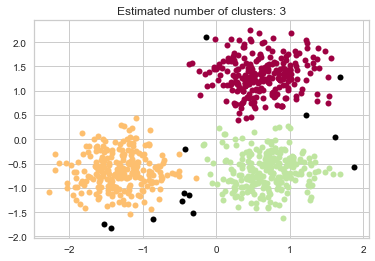

In [53]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=8).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % completeness_score(labels_true, labels))
print("V-measure: %0.3f" % v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % adjusted_mutual_info_score(labels_true, labels))

# Plot result
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### HDBSCAN

Estimated number of clusters: 3
Estimated number of noise points: 29
Homogeneity: 0.931
Completeness: 0.838
V-measure: 0.882
Adjusted Rand Index: 0.925
Adjusted Mutual Information: 0.882


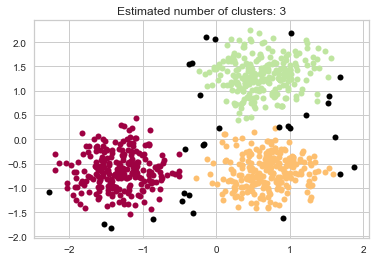

In [56]:
# Compute HDBSCAN
db = HDBSCAN().fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % completeness_score(labels_true, labels))
print("V-measure: %0.3f" % v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % adjusted_mutual_info_score(labels_true, labels))

# Plot result
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Final Remarks - Guiding Principles

## Don’t be wrong! 

If you are doing EDA, you are trying extract the signal from the noise --the structure from the seemingly unstructured-- ORDER from CHAOS. 

In my opinion it is better to get no result than a wrong result. That is, it is better not to understand your data, than to misunderstand your data. 

Chasing wild geese can be costly and not fun.

## Keep it simple!

Many algorithms have highly sensitive parameters and have many assumptions, which may be violated.

It is better to err on the side of overly simplistic and therefore easily understood, than to venture off into overly complicated and unintuitive methods.

## Stability is key!

Just because an algorithm converges, does not mean the solution is stable. If you re-run your clustering, but with a different random initialization or with a different sample, you expect to get roughly the same clusters back. If this is not the case, something is wrong. Either the clusters found are useless or there are problems with your sampling methodology.

Double check your cluster assignments.

## Scalability!

A clustering algorithm is not useful if it has to be run on such a small sub-sample of the data that we risk losing a good representation of the whole population.

It is better to use a scalable methodology even if it is weaker than trying to scale an overly complex and expensive methodology.

## Outliers!

As we have have said before, Signal-to-Noise will be important to consider for clustering. 

It is better to use a soft-clustering method which can handle outliers.

## First Principles!

Not only is it important which raw features you choose to cluster on, but which synthetic (engineered) features you use. Start with first principles approach and think about the nature of the beast. What could be useful information to cluster on that you may need to create features to capture?

Always proceed in the following order:

* Is there a natural segmentation already in my data?
* What segmentation do I suspect could be captured from my data and would be useful to solving the business problem?
* What features will be indicative of those segments?
* What else would be useful information that I might be able to proxy / or get elsewhere --even though I don't currently have data to capture the effects directly?
* Should I try to get more data from other sources to enhance what I have already done? Or is this good enough?

And if all this fails, then proceed with blind search --but only if necessary.

-----

# References / Resources

* Clustering 101:
    * https://www.analyticsvidhya.com/blog/2016/11/an-introduction-to-clustering-and-different-methods-of-clustering/
    * https://scikit-learn.org/stable/modules/clustering.html#
    * https://stats.stackexchange.com/questions/77689/estimating-the-most-important-features-in-a-k-means-cluster-partition
    * https://www.analyticsvidhya.com/blog/2013/11/getting-clustering-right/


* Variable Clustering:
    * https://github.com/jingmin1987/variable-clustering/blob/master/demo.ipynb
    * https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb
    

* Embeddings (Manifold Learning):
    * https://umap-learn.readthedocs.io/en/latest/index.html
    * https://github.com/egolinko/qGELpy


* Mixture Methods:
    * https://www.analyticsvidhya.com/blog/2019/10/gaussian-mixture-models-clustering/
    * https://scikit-learn.org/stable/modules/mixture.html#
    * https://scikit-lego.readthedocs.io/en/latest/mixture-methods.html


* Clustering Algorithms:
    * https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
    * https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN
    * https://hdbscan.readthedocs.io/en/latest/index.html
    * https://github.com/nicodv/kmodes
    * https://scikit-learn.org/stable/auto_examples/cluster/plot_inductive_clustering.html
